## 1. HANA Cloud 연결하기
### 1) Jupyter Notebook file (01_HANA_Vector_table_contents.ipynb) 생성하기
### 2) Library Import
HANA Cloud에 연결하기 위한 파이썬 라이브러리를 import 한다.

`Shift` + `Enter` : shell 실행

In [2]:
import pandas as pd
import json
import os
import hana_ml
from hana_ml import ConnectionContext

print(pd.__version__)
print(hana_ml.__version__)

2.2.0
2.19.24022101


C:\Users\CESCO\AppData\Local\Temp\ipykernel_83828\2357728272.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 3) Jupyter NoteBook에서 HANA 테이블 연결
1. HANA Cloud에 연결하기 위해 `HANA configure.json` 파일을 로드합니다.
2. **ConnectionContext** : Port, user, url, pwd를 통해 HANA Cloud에 연결합니다.
3. **SET SCHEMA GEN_AI** : HANA Cloud에 연결이 완료되면, 튜토리얼 실행을 위한 GEN_AI 스키마를 선택해줍니다.

In [3]:
#Connect HANA Table
with open(os.path.join(os.getcwd(), 'E:\Enablement-hands-on\HANA-configure-teon.json')) as f:
    hana_env_c = json.load(f)
    port_c = hana_env_c['port']
    user_c = hana_env_c['user']
    host_c = hana_env_c['host']
    pwd_c = hana_env_c['pwd']

cc = ConnectionContext(address=host_c, port=port_c, user=user_c, password=pwd_c, encrypt=True)
cursor = cc.connection.cursor()
cursor.execute("""SET SCHEMA GEN_AI""")

#Check hana_ml version
print(cc.hana_version())
#Check current schema
print(cc.get_current_schema())

4.00.000.00.1713874676 (CE2024.14)
GEN_AI


### 4) dataset.csv 데이터 로드하기
- dataset download link: https://github.com/smlee-tech/sap-kr-genai-enablementsession01/blob/main/data/dataset.csv
- 해당 csv 파일은 Kaggle의 IKEA 일부 데이터를 활용하여, 새롭게 가공한 Tutorial용 데이터셋입니다.
- BlockID: Index column으로 활용하기 위해 Block ID Column을 새롭게 생성합니다.

In [4]:
data = pd.read_csv('../data/dataset.csv', index_col=False) # index_col=False는 CSV 파일을 읽을 때 첫 번째 열을 데이터프레임의 인덱스로 사용하지 않도록 지정한다.

data['BlockID'] = range(1, len(data) +1)
print(data.columns)

Index(['MaterialNumber', 'MaterialName', 'PurchasingGroupDescription',
       'PurchasingGroup', 'MaterialDescription', 'Total_stock',
       'Unrestricted_use_stock', 'Blocked_stock', 'Block_reason',
       'Blocked_date', 'Solution_date', 'Solution',
       'PurchasingGroupDescription_KR', 'MaterialDescription_KR',
       'Solution_KR', 'Block_reason_KR', 'BlockID'],
      dtype='object')


### 5) Column 재정렬 하기
1. data의 Column 순서를 재정렬합니다.
2. 재정렬한 데이터프레임 Data1의 데이터 타입 및 Non-null count를 확인합니다.

In [4]:
data1 = data[['BlockID', 'MaterialNumber', 'MaterialName', 'MaterialDescription', 'MaterialDescription_KR',
                'PurchasingGroup', 'PurchasingGroupDescription', 'PurchasingGroupDescription_KR','Total_stock',
                'Unrestricted_use_stock','Blocked_stock', 'Blocked_date', 'Block_reason', 'Block_reason_KR', 
                'Solution', 'Solution_KR','Solution_date']]
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   BlockID                        10 non-null     int64 
 1   MaterialNumber                 10 non-null     int64 
 2   MaterialName                   10 non-null     object
 3   MaterialDescription            10 non-null     object
 4   MaterialDescription_KR         10 non-null     object
 5   PurchasingGroup                10 non-null     object
 6   PurchasingGroupDescription     10 non-null     object
 7   PurchasingGroupDescription_KR  10 non-null     object
 8   Total_stock                    10 non-null     int64 
 9   Unrestricted_use_stock         10 non-null     int64 
 10  Blocked_stock                  10 non-null     int64 
 11  Blocked_date                   10 non-null     object
 12  Block_reason                   10 non-null     object
 13  Block_re

## 2.HANA 테이블 생성하기
1. 연결된 HANA Cloud를 활용하여, 새로운 HANA Cloud Table을 생성한다.
2. Table Name: `BLOCK_{User_Name or User_ID}`
※User_Name or User_ID: 이름 혹은, BTP account로 사용하고 있는 Email의 ID 사용 권장
3. HANA Explorer에서 생성된 Column Name, SQL Data Type 확인

In [8]:
cursor = cc.connection.cursor()
sql_command = '''CREATE TABLE "DEMO_BLOCK_TEON"(
    "BlockID" BIGINT,
    "MaterialNumber" BIGINT,
    "MaterialName" NCLOB MEMORY THRESHOLD 0,
    "MaterialDescription" NCLOB MEMORY THRESHOLD 0,
    "MaterialDescription_KR" NCLOB MEMORY THRESHOLD 0,
    "PurchasingGroup" NVARCHAR(100),
    "PurchasingGroupDescription" NVARCHAR(5000),
    "PurchasingGroupDescription_KR" NVARCHAR(5000),
    "Total_stock" BIGINT,
    "Unrestricted_use_stock" BIGINT,
    "Blocked_stock" BIGINT,
    "Blocked_date" DATE,
    "Block_reason" NCLOB MEMORY THRESHOLD 0,
    "Block_reason_KR" NCLOB MEMORY THRESHOLD 0,
    "Solution" NCLOB MEMORY THRESHOLD 0,
    "Solution_KR" NCLOB MEMORY THRESHOLD 0,
    "Solution_date" DATE
)'''

cursor.execute(sql_command)
cursor.close()

`NCLOB MEMORY THRESHOLD`
- NCLOB: 큰 문자 객체를 저장하는데 사용됨.
- MEMORY THRESHOLD 0: 모든 데이터를 메모리에 저장하도록 지정한다.

`NVARCHAR(5000)`
- 최대 5000자의 가변 길이 유니코드 문자열 

## 3.HANA Cloud에 Dataset 업로드
### 1) 날짜 포맷 변환
HANA Cloud에서 인식할 수 있도록, data2의 Blocked_date, Solution_Date column의 타입을 datetime으로 변경한다.

In [9]:
data2 = data1.copy()
data2['Blocked_date'] = pd.to_datetime(data2['Blocked_date'])
data2['Solution_date'] = pd.to_datetime(data2['Solution_date'])

C:\Users\CESCO\AppData\Local\Temp\ipykernel_2744\3690285358.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data2['Blocked_date'] = pd.to_datetime(data2['Blocked_date'])
C:\Users\CESCO\AppData\Local\Temp\ipykernel_2744\3690285358.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data2['Solution_date'] = pd.to_datetime(data2['Solution_date'])


In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   BlockID                        10 non-null     int64         
 1   MaterialNumber                 10 non-null     int64         
 2   MaterialName                   10 non-null     object        
 3   MaterialDescription            10 non-null     object        
 4   MaterialDescription_KR         10 non-null     object        
 5   PurchasingGroup                10 non-null     object        
 6   PurchasingGroupDescription     10 non-null     object        
 7   PurchasingGroupDescription_KR  10 non-null     object        
 8   Total_stock                    10 non-null     int64         
 9   Unrestricted_use_stock         10 non-null     int64         
 10  Blocked_stock                  10 non-null     int64         
 11  Blocked_date          

### 2) HANA Cloud에 데이터 업로드
data2에 데이터 프레임을 HANA Cloud에 업로드한다.

In [11]:
#import dataframe into hana table
from hana_ml.dataframe import create_dataframe_from_pandas
v_hdf = create_dataframe_from_pandas(
    connection_context=cc,
    pandas_df=data2,
    table_name="DEMO_BLOCK_TEON",
    allow_bigint=True,
    append=True,
    force=False
)

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


### 3)업로드 데이터 확인
1. HANA Explorer를 활용하여 HANA Cloud에 업로드된 dataframe을 확인한다.
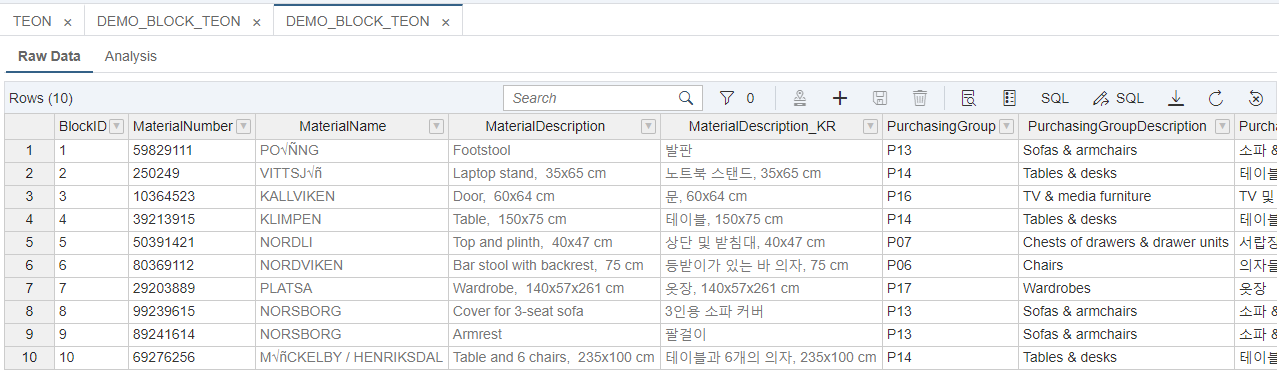

2. SQL Query를 활용하여 업로드된 dataframe을 확인한다.

In [12]:
hdf = cc.sql('''SELECT TOP 10 "BlockID", "MaterialNumber",
             "MaterialName", "Blocked_stock", "Block_reason", "Blocked_date",
             "Solution", "Solution_KR", "Solution_date"
             FROM DEMO_BLOCK_TEON''')
df_abstract = hdf.collect()
df_abstract.head()

,BlockID,MaterialNumber,MaterialName,Blocked_stock,Block_reason,Blocked_date,Solution,Solution_KR,Solution_date
0,1,59829111,PO√ÑNG,2695,Safety concerns trigger an urgent recall of sp...,2024-01-20,"[{""Instruction_step"": 1, ""Instruction"": ""Ident...","[{""Instruction_step"": 1, ""Instruction_KR"": ""영향...",2024-01-31
1,2,250249,VITTSJ√ñ,34657,Identification of packaging defects that compr...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...","[{""Instruction_step"": 1, ""Instruction_KR"": ""현재...",2024-04-23
2,3,10364523,KALLVIKEN,2262,Extended customs hold for certain shipments du...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction"": ""Provi...","[{""Instruction_step"": 1, ""Instruction_KR"": ""관세...",2024-05-06
3,4,39213915,KLIMPEN,21111,Critical feedback on packaging quality leading...,2024-06-20,"[{""Instruction_step"": 1, ""Instruction"": ""Gathe...","[{""Instruction_step"": 1, ""Instruction_KR"": ""중요...",2024-06-27
4,5,50391421,NORDLI,23208,Discrepancies in item quantity received by cus...,2024-05-06,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...","[{""Instruction_step"": 1, ""Instruction_KR"": ""주문...",2024-05-08


## 4.HANA 벡터 타입 컬럼 생성
### 1)HANA Vector Type column 생성
HANA Cloud Table에 새로운 Vector Column을 생성한다.

In [27]:
cursor = cc.connection.cursor()
sql_command = '''ALTER TABLE DEMO_BLOCK_TEON ADD(VECTOR_EN REAL_VECTOR(1536))'''
cursor.execute(sql_command)
cursor.close()

ProgrammingError: (308, 'column name already exists: VECTOR_EN: line 1 col 33 (at pos 32)')

`REAL_VECTOR(1536)`: embedding vector의 dimension을 지정한다.

- HANA Explorer에서 업로드 확인
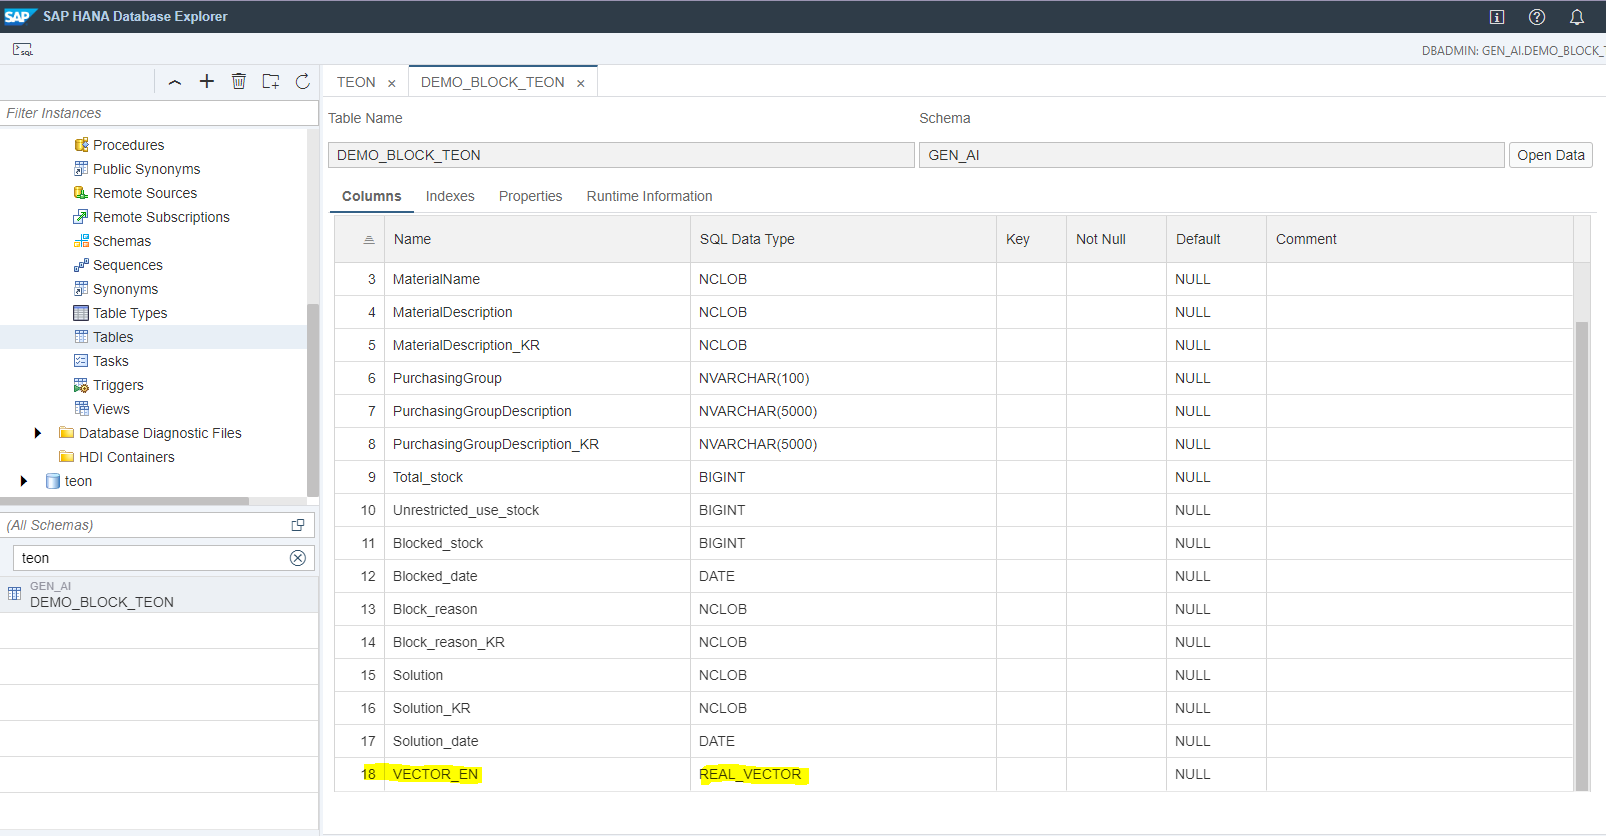

In [29]:
#Vector KR도 추가해준다
cursor = cc.connection.cursor()
sql_command = '''ALTER TABLE DEMO_BLOCK_TEON ADD(VECTOR_KR REAL_VECTOR(1536))'''
cursor.execute(sql_command)
cursor.close()

ProgrammingError: (308, 'column name already exists: VECTOR_KR: line 1 col 33 (at pos 32)')

## 5.Vector Embedding
### 1) Generative AI Hub에서 Deployment ID를 확인하여, embedding function을 생성한다.
Generative AI Hub에서 설정된 embedding 모델을 활용하기 위한 Embedding function을 생성한다.
1. 모델 사용을 위한 Deployment ID를 Generative AI Hub로 부터 가져온다.
2. Generative AI Hub의 프록시 라이브러리를 사용하여, Deployment ID로 Embedding model을 사용하기 위한 embedding function을 생성한다.

In [15]:
# get embedding
from gen_ai_hub.proxy.native.openai import embeddings

#azure-openai-text-embedding 모델
def get_embedding(input, model = "dc872f9eef04c31a") -> str:
    response = embeddings.create(
        deployment_id = model,
        input = input
    )
    return response.data[0].embedding

### 2) Embedding Test
위에서 생성한 `embedding function`의 기능 테스트

In [16]:
#Test
get_embedding("I'm here to learn about your world.")

[0.0005539925768971443,
 -0.00851188600063324,
 0.025113264098763466,
 -0.03512272983789444,
 -0.02575325407087803,
 0.026649242267012596,
 -0.0036575510166585445,
 0.003644751152023673,
 -0.022425299510359764,
 -0.024409273639321327,
 -0.01086705457419157,
 -0.014028611592948437,
 0.009862267412245274,
 -0.014962999150156975,
 0.008723082952201366,
 -0.023526085540652275,
 0.01939173974096775,
 -0.00937587395310402,
 -0.0008455886854790151,
 -0.004137544427067041,
 -0.01265903003513813,
 -0.0004131944733671844,
 0.030130796134471893,
 -0.008499085903167725,
 -0.0037471498362720013,
 -0.007551898714154959,
 -1.9987232008134015e-05,
 -0.011897440999746323,
 -0.006873507983982563,
 -0.022079704329371452,
 0.005366328172385693,
 0.018841346725821495,
 0.017356567084789276,
 -0.013862214051187038,
 -0.007903894409537315,
 -0.032204367220401764,
 0.016575777903199196,
 -0.019673336297273636,
 0.0034943532664328814,
 -0.016678176820278168,
 0.006028719246387482,
 0.001955173909664154,
 -0.00

### 3) Data frame을 활용하여 context column 생성
- Similarity Search를 사용하기 위해, 여러 칼럼의 데이터를 활용하여 해당 데이터셋에 대한 context column을 생성합니다.
- 여기서는 한국어와 영어를 구분하여 Context column을 개별적으로 생성함.

In [18]:
data2['Context'] = 'Block reason:' + data2['Block_reason'] \
                    + '\n Material Number:' + data2['MaterialNumber'].astype(str) \
                    + '\n Material Name:' + data2['MaterialName'] \
                    + '\n Material Description:' + data2['MaterialDescription'] \
                    + '\n Purchasing Group:' + data2['PurchasingGroup'] \
                    + '\n Purchasing Group Description:' + data2['PurchasingGroupDescription']

data2['Context_KR'] = '블럭 원인:' + data2['Block_reason_KR'] \
                    + '\n 자재 번호:' + data2['MaterialNumber'].astype(str) \
                    + '\n 자재명:' + data2['MaterialName'] \
                    + '\n 자재 설명:' + data2['MaterialDescription_KR'] \
                    + '\n 자재 그룹:' + data2['PurchasingGroup'] \
                    + '\n 구매 그룹 설명:' + data2['PurchasingGroupDescription_KR']

### 4) Embedding
BlockID column 기준으로 Context & Context_KR column 임베딩을 진행한다.<br/>
BlockID를 기준으로, row 단위로 임베딩 진행

In [31]:
#generate embeddings from the text
rows = []
rows_kr = []

for index, row in data2.iterrows():
    text = row['Context']
    #print(text)
    try:
        text_vector = get_embedding(input=text, model="dc872f9eef04c31a")
        myrow = (str(text_vector), row['BlockID'])
        rows.append(myrow)
    except Exception as e:
        print(e)


for index, row in data2.iterrows():
    text_kr = row['Context_KR']
    #print(text)
    try:
        text_vector_kr = get_embedding(input=text_kr, model="dc872f9eef04c31a")
        myrow_kr = (str(text_vector_kr), row['BlockID'])
        rows_kr.append(myrow_kr)
    except Exception as e:
        print(e)

In [32]:
print(rows[0])
print(rows_kr[0])

('[0.01642700284719467, -0.014308784157037735, -0.014085434377193451, -0.01176548097282648, -0.027767399325966835, 0.03501545265316963, -0.042681388556957245, -0.016830474138259888, -0.0035393706057220697, -0.013278493657708168, 0.007557862438261509, -0.0005421631503850222, -0.025087203830480576, 0.012039263732731342, -0.03717690333724022, 0.021340694278478622, 0.007579477038234472, 0.01858845166862011, 0.0004361171158961952, -0.0018984716152772307, -0.0012923656031489372, 0.03270990774035454, -0.018660498782992363, 0.015115724876523018, -0.010202033445239067, 0.002907147165387869, 0.048531707376241684, -0.0341796949505806, -0.0170898474752903, -0.00012856110697612166, 0.01982768066227436, -0.043200135231018066, -0.025087203830480576, -0.01553360465914011, -0.0116069745272398, 0.0005980005371384323, -0.016196448355913162, -0.0016408991068601608, 0.0025505083613097668, -0.018703728914260864, 0.027796218171715736, 0.019251294434070587, 0.00598721019923687, 0.005335173569619656, 0.0086962

## 6. HANA Table에 Vector Embedding 업로드
### 1) Embedding 결과 HANA Table 업로드
Embedding된 데이터를 HANA Cloud Tale에 업로드한다.

In [24]:
#bulk update
#cc.connectin.setautocommit(False)
cursor = cc.connection.cursor()
sql = 'UPDATE DEMO_BLOCK_TEON SET VECTOR_EN = TO_REAL_VECTOR(?) WHERE "BlockID" = ?'
try:
    cursor.executemany(sql, rows)
except Exception as e:
    cc.connection.rollback()
    print("An error occurred:", e)
try:
    cc.connection.commit()
finally:
    cursor.close()
cc.connection.setautocommit(True)

In [33]:
#bulk update
#cc.connectin.setautocommit(False)
cursor = cc.connection.cursor()
sql = 'UPDATE DEMO_BLOCK_TEON SET VECTOR_KR = TO_REAL_VECTOR(?) WHERE "BlockID" = ?'
try:
    cursor.executemany(sql, rows_kr)
except Exception as e:
    cc.connection.rollback()
    print("An error occurred:", e)
try:
    cc.connection.commit()
finally:
    cursor.close()
cc.connection.setautocommit(True)

### 2) HANA Table에서 Embedding 확인하기
HANA Cloud Table에 연결하여 Embedding된 결과 값을 확인한다.

In [34]:
# Check Updates
hdf = cc.sql('''SELECT TOP 5 "BlockID","MaterialNumber", "MaterialName",
                "Blocked_stock","Block_reason","Blocked_date", "Solution",
                "Solution_KR","Solution_date", "VECTOR_KR"
                FROM DEMO_BLOCK_TEON''')
df_abstract = hdf.collect()
df_abstract.head()

,BlockID,MaterialNumber,MaterialName,Blocked_stock,Block_reason,Blocked_date,Solution,Solution_KR,Solution_date,VECTOR_KR
0,1,59829111,PO√ÑNG,2695,Safety concerns trigger an urgent recall of sp...,2024-01-20,"[{""Instruction_step"": 1, ""Instruction"": ""Ident...","[{""Instruction_step"": 1, ""Instruction_KR"": ""영향...",2024-01-31,"[0, 6, 0, 0, 178, 206, 196, 187, 195, 47, 200,..."
1,2,250249,VITTSJ√ñ,34657,Identification of packaging defects that compr...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...","[{""Instruction_step"": 1, ""Instruction_KR"": ""현재...",2024-04-23,"[0, 6, 0, 0, 86, 57, 26, 188, 244, 158, 76, 18..."
2,3,10364523,KALLVIKEN,2262,Extended customs hold for certain shipments du...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction"": ""Provi...","[{""Instruction_step"": 1, ""Instruction_KR"": ""관세...",2024-05-06,"[0, 6, 0, 0, 114, 28, 15, 59, 0, 12, 233, 188,..."
3,4,39213915,KLIMPEN,21111,Critical feedback on packaging quality leading...,2024-06-20,"[{""Instruction_step"": 1, ""Instruction"": ""Gathe...","[{""Instruction_step"": 1, ""Instruction_KR"": ""중요...",2024-06-27,"[0, 6, 0, 0, 69, 123, 19, 188, 150, 9, 225, 18..."
4,5,50391421,NORDLI,23208,Discrepancies in item quantity received by cus...,2024-05-06,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...","[{""Instruction_step"": 1, ""Instruction_KR"": ""주문...",2024-05-08,"[0, 6, 0, 0, 13, 251, 61, 188, 26, 157, 177, 1..."
